In [2]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [3]:
# sc = SparkContext.getOrCreate()
conf = SparkConf()
sc = SparkContext.getOrCreate(conf=conf)

In [4]:
# Macros.
MAX_ITER = 20
# gs://yy3089_data_storage/data/HW1_data/
DATA_PATH = "data.txt"
C1_PATH = "c1.txt"
C2_PATH = "c2.txt"
NORM = 2

In [5]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

def toArray(l):
    return np.array([float(x) for x in l])

def mergeSet(x, y):
    l = min(len(x), len(y))
    return tuple(x[_] + y[_] for _ in range(l))


In [6]:
# K-means clustering
def kmeans(data, centroids, norm):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    # data: list of np.array
    data_np = data.map(lambda l: l.split(' ')).map(lambda x: toArray(x)).collect()

    points = []
    costs = []

    # iterative k-means
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        # print('Iter %d' % _)

        points = []
        distance = 0
        
        for p in data_np:
            index = closest(p, centroids, norm)
            centroid = centroids[index]

            distance += linalg.norm(centroid-p, norm)**norm
            points.append((index, (p, 1)))

        # record total cost
        costs.append((_, distance))
        # generate points RDD
        points = sc.parallelize(points)

        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        # Average the points for each centroid: divide sum of points by count
        # points_sum = (index, (sum_points, sum_count))
        points_sum = points.reduceByKey(lambda x, y: mergeSet(x, y)).collect()

        for key, val in points_sum:
            # print('For centroid %d, there are %d points' % (key, val[1]))
            centroids[key] = val[0]/val[1]

    costs = sc.parallelize(costs)
    return points, centroids, costs

    # Use collect() to turn RDD into list

In [7]:
data = sc.textFile(DATA_PATH)
c1 = sc.textFile(C1_PATH)
c2 = sc.textFile(C2_PATH)

# cx_np: list of float
c1_np = c1.map(lambda l: l.split(' ')).map(lambda x: toArray(x)).collect()
c2_np = c2.map(lambda l: l.split(' ')).map(lambda x: toArray(x)).collect()

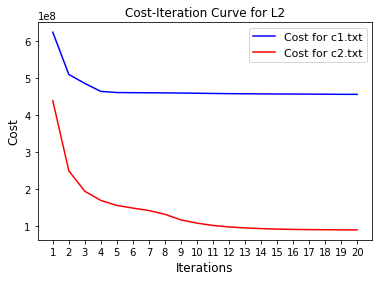

In [8]:
points1, centroids1, costs1 = kmeans(data, c1_np, NORM)
iter_list = costs1.keys().collect()
cost_list = costs1.values().collect()
plt.plot(iter_list, cost_list, 'b-', label = 'Cost for c1.txt')

points2, centroids2, costs2 = kmeans(data, c2_np, NORM)
iter_list = costs2.keys().collect()
cost_list = costs2.values().collect()
plt.plot(iter_list, cost_list, 'r-', label = 'Cost for c2.txt')

plt.xticks(iter_list, [_ for _ in range(1, 21)])

plt.ylabel("Cost", fontdict={'weight': 'normal', 'size': 12})
plt.xlabel("Iterations", fontdict={'weight': 'normal', 'size': 12})
plt.legend(loc = 'upper right', prop={'size' : 11})
plt.title('Cost-Iteration Curve for L%d' % NORM)

plt.savefig('cost_L%d.jpg' % NORM)

In [9]:
from sklearn.manifold import TSNE

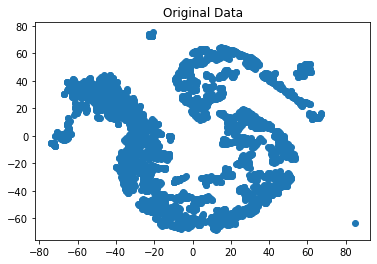

In [10]:
indexes = points1.map(lambda x: x[0]).collect()
coordinators = points1.map(lambda x: x[1][0]).collect()
coordinators_embedded = TSNE(n_components=2,
                           random_state=100).fit_transform(coordinators)

vis_x = coordinators_embedded[:, 0]
vis_y = coordinators_embedded[:, 1]
plt.scatter(vis_x, vis_y, cmap=plt.cm.get_cmap('jet', 10))
plt.title('Original Data')
# plt.show()
plt.savefig('origin.jpg')

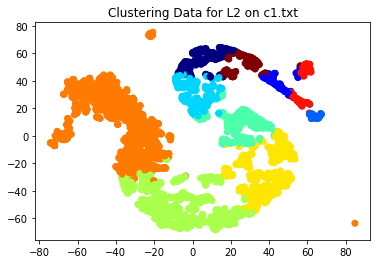

In [11]:
scatter = plt.scatter(vis_x, vis_y,
                      marker='o', c=indexes, cmap='jet')
    
plt.title('Clustering Data for L%d on c1.txt' % NORM)
plt.savefig('c1_clustering.jpg')

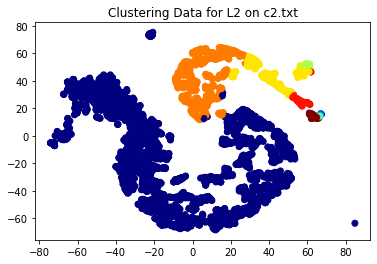

In [14]:
indexes = points2.map(lambda x: x[0]).collect()

scatter = plt.scatter(vis_x, vis_y,
                      marker='o', c=indexes, cmap='jet')

plt.title('Clustering Data for L%d on c2.txt' % NORM)
# plt.show()
plt.savefig('c2_clustering.jpg')